In [3]:
from datacube.virtual import catalog_from_file, construct_from_yaml, Transformation, DEFAULT_RESOLVER
from dea_tsmask import tsmask_temporal

import datacube
import xarray as xr

import sys
sys.path.append('../Scripts')
import dea_datahandling
from dea_plotting import rgb

In [7]:
#The Class and functions below assist with creating the time-series mask

class TSMask(Transformation):
    def compute(self, data):
        chunks = dict(time=-1)
        result = xr.apply_ufunc(tsmask_temporal,
                                data.avg.chunk(chunks), data.mndwi.chunk(
                                    chunks), data.msavi.chunk(chunks),
                                dask='parallelized', output_dtypes=['uint8']).assign_attrs(nodata=0, units='1')
        return result.to_dataset(name='classification').assign_attrs(**data.attrs)

    def measurements(self, input_measurements):
        return {'classification': Measurement(name='classification', dtype='uint8', nodata=0, units='1')}

def load_catalog():
    resolver = DEFAULT_RESOLVER.clone()
    resolver.register('transform', 'tsmask', TSMask)
    return catalog_from_file('../../dea-tsmask/virtual-product-catalog.yaml',
                             name_resolver=resolver)

catalog = load_catalog()

In [75]:
dc = datacube.Datacube(app='TSmask_testing')

query = {'x': (122.17, 122.26),
         'y': (-18.17, -18.23),
         'output_crs': 'EPSG:3577',
         'resolution': (-20, 20),
         'time': ('2017-01', '2017-12-31')}


# this will compute the ts cloud mask
print('calculating cloud_mask')
cloud_mask = catalog['s2_tsmask'].load(dc, **query)
cloud_mask = cloud_mask.compute()

calculating cloud_mask


/usr/local/lib/python3.6/dist-packages/dask/array/blockwise.py:241: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


In [76]:
# # load the raw, unmasked Sentinel data (only the bands we're interested in)
bands = ['nbart_blue','nbart_green', 'nbart_red']

query['measurements'] = bands
sentinel_ds = dea_datahandling.load_ard(dc=dc,
                                        mask_pixel_quality=False,
                                        mask_invalid_data=False,
                                        products=['s2a_ard_granule',
                                                  's2b_ard_granule'],
                                        **query)

# # mask the sentinel data with the cloud mask
sentinel_ds = sentinel_ds.where(cloud_mask.classification.isin([1, 4, 5]))

Loading s2a_ard_granule data
Loading s2b_ard_granule data
Combining and sorting data
    Returning 32 observations 


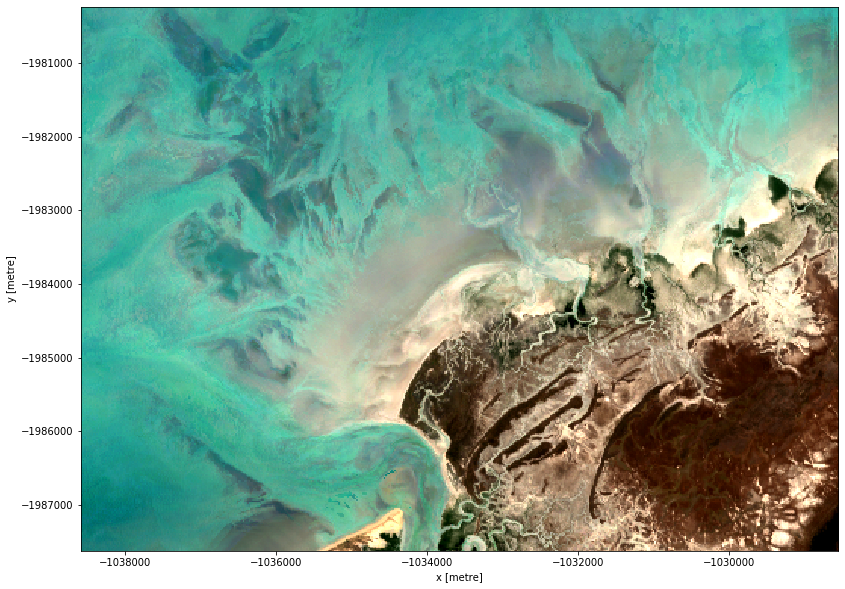

In [77]:
rgb(sentinel_ds.median(dim='time'), size=10, percentile_stretch = (0.01, 0.99))

Loading s2a_ard_granule data
    Applying pixel quality mask
Loading s2b_ard_granule data
    Applying pixel quality mask
Combining and sorting data
    Returning 32 observations 


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


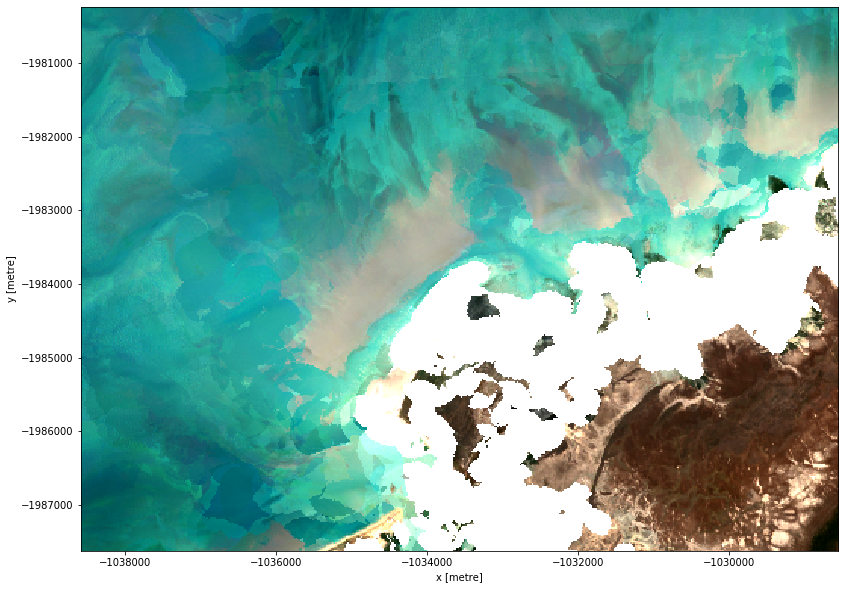

In [78]:
sentinel_ds2 = dea_datahandling.load_ard(dc=dc,
                                        mask_pixel_quality=True,
                                        mask_invalid_data=False,
                                        products=['s2a_ard_granule',
                                                  's2b_ard_granule'],
                                        **query)

rgb(sentinel_ds2.median(dim='time'), size=10, percentile_stretch=(0.01, 0.99))

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


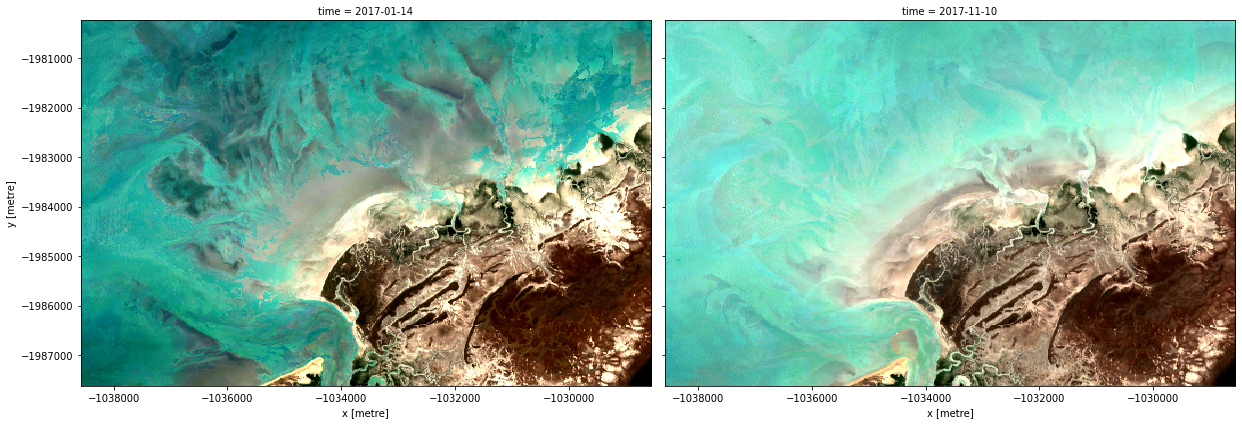

In [87]:
rgb(sentinel_ds.resample(time='300d').median(dim='time'), col='time')